In [1]:
# MEDICAL IMAGE FUSION FINE-TUNING
# Fine-tune pre-trained visible-infrared model for CT-MRI fusion
# Based on the improved fusion architecture from LLVIP training

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torch.cuda import amp
from tqdm import tqdm
import cv2
import numpy as np
from PIL import Image
import os
import random
import matplotlib.pyplot as plt
import warnings
import nibabel as nib
from skimage import exposure, filters
import json
from pathlib import Path
import pandas as pd
warnings.filterwarnings('ignore')

# Fix multiprocessing
import torch.multiprocessing as mp
try:
    mp.set_start_method('spawn', force=True)
    print("Set multiprocessing start method to 'spawn'")
except RuntimeError:
    pass

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Set multiprocessing start method to 'spawn'
Using device: cuda


In [2]:
# ================================
# MEDICAL IMAGE FUSION CONFIGURATION
# ================================

config = {
    # Training parameters
    'batch_size': 4,          # Smaller batch for medical images
    'lr': 1e-5,              # Much lower LR for fine-tuning
    'num_epochs': 30,         # Fewer epochs for fine-tuning
    'device': device,
    'pretrained_model_path': 'pretrained/pretrained.pth',  # Your pre-trained model
    'save_path': 'checkpoints/final/medical_fusion_finetuning/medical_fusion_finetuned.pth',
    'checkpoint_dir': 'checkpoints/intermediate/medical_fusion_finetuning',
    'results_dir': 'results/medical_fusion_finetuning',
    'plots_dir': 'results/medical_fusion_finetuning/plots',
    'image_size': (256, 256),
    'num_workers': 0,
    
    # Fine-tuning specific
    'freeze_encoder_epochs': 5,    # Freeze encoder for first 5 epochs
    'warmup_epochs': 3,           # Gradual warmup
    'gradient_clip': 1.0,         # Gradient clipping for stability
    
    # Medical-specific loss weights (different from natural images)
    'w_content': 15.0,        # Higher - medical content is critical
    'w_structure': 8.0,       # Higher - anatomical structure preservation
    'w_detail': 5.0,          # Important for diagnostic details
    'w_consistency': 3.0,     # Moderate consistency requirement
    'w_gradient': 2.0,        # Edge preservation for boundaries
    'w_medical': 10.0,        # NEW: Medical-specific loss component
    
    # Data paths
    'ct_train_path': '../Dataset/train/CT',
    'mri_train_path': '../Dataset/train/MRI', 
    'ct_val_path': '../Dataset/val/CT',
    'mri_val_path': '../Dataset/val/MRI',
    'ct_test_path': '../Dataset/test/CT',
    'mri_test_path': '../Dataset/test/MRI',
    
    # Medical image parameters
    'ct_window_center': 40,    # Typical for soft tissue
    'ct_window_width': 400,
    'normalize_intensities': True,
    'enhance_contrast': True,
}

print("Medical Image Fusion Configuration:")
for key, value in config.items():
    print(f'  {key}: {value}')

Medical Image Fusion Configuration:
  batch_size: 4
  lr: 1e-05
  num_epochs: 30
  device: cuda
  pretrained_model_path: pretrained/pretrained.pth
  save_path: checkpoints/final/medical_fusion_finetuning/medical_fusion_finetuned.pth
  checkpoint_dir: checkpoints/intermediate/medical_fusion_finetuning
  results_dir: results/medical_fusion_finetuning
  plots_dir: results/medical_fusion_finetuning/plots
  image_size: (256, 256)
  num_workers: 0
  freeze_encoder_epochs: 5
  warmup_epochs: 3
  gradient_clip: 1.0
  w_content: 15.0
  w_structure: 8.0
  w_detail: 5.0
  w_consistency: 3.0
  w_gradient: 2.0
  w_medical: 10.0
  ct_train_path: ../Dataset/train/CT
  mri_train_path: ../Dataset/train/MRI
  ct_val_path: ../Dataset/val/CT
  mri_val_path: ../Dataset/val/MRI
  ct_test_path: ../Dataset/test/CT
  mri_test_path: ../Dataset/test/MRI
  ct_window_center: 40
  ct_window_width: 400
  normalize_intensities: True
  enhance_contrast: True


In [3]:
# ================================
# MEDICAL IMAGE PREPROCESSING UTILITIES
# ================================

class MedicalImageProcessor:
    """Specialized preprocessing for medical images"""
    
    @staticmethod
    def load_dicom_or_nifti(filepath):
        """Load medical image from various formats"""
        filepath = str(filepath)
        
        if filepath.endswith('.nii') or filepath.endswith('.nii.gz'):
            # NIfTI format
            img = nib.load(filepath)
            data = img.get_fdata()
            # Take middle slice if 3D
            if len(data.shape) == 3:
                data = data[:, :, data.shape[2]//2]
            return data.astype(np.float32)
            
        elif filepath.endswith('.dcm'):
            # DICOM format (requires pydicom)
            try:
                import pydicom
                ds = pydicom.dcmread(filepath)
                data = ds.pixel_array.astype(np.float32)
                return data
            except ImportError:
                print("Warning: pydicom not installed, falling back to image loader")
                
        # Fall back to regular image formats
        img = cv2.imread(filepath, cv2.IMREAD_UNCHANGED)
        if img is None:
            img = np.array(Image.open(filepath).convert('L'))
        return img.astype(np.float32)
    
    @staticmethod
    def apply_ct_windowing(img, center=40, width=400):
        """Apply CT windowing (HU units)"""
        min_val = center - width // 2
        max_val = center + width // 2
        img = np.clip(img, min_val, max_val)
        img = (img - min_val) / (max_val - min_val)
        return img
    
    @staticmethod
    def normalize_medical_image(img, modality='CT'):
        """Normalize medical image intensities"""
        if modality.upper() == 'CT':
            # CT images might be in HU units
            if img.min() < -500:  # Likely HU units
                img = MedicalImageProcessor.apply_ct_windowing(
                    img, config['ct_window_center'], config['ct_window_width']
                )
            else:
                # Already normalized or different scale
                img = (img - img.min()) / (img.max() - img.min() + 1e-8)
        else:
            # MRI - simple min-max normalization
            img = (img - img.min()) / (img.max() - img.min() + 1e-8)
            
        return img
    
    @staticmethod
    def enhance_medical_contrast(img):
        """Enhance contrast for better fusion"""
        # Ensure image is in correct format for CLAHE
        if img.dtype != np.float32:
            img = img.astype(np.float32)
        
        # Handle multi-channel images by converting to grayscale
        if len(img.shape) > 2:
            img = np.mean(img, axis=-1)
        
        # Ensure values are in [0, 1] range
        img = np.clip(img, 0, 1)
        
        # Convert to uint8 for CLAHE
        img_uint8 = (img * 255).astype(np.uint8)
        
        # Apply CLAHE
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        enhanced = clahe.apply(img_uint8)
        
        # Convert back to float32 in [0, 1] range
        return enhanced.astype(np.float32) / 255.0
    
    @staticmethod
    def prepare_medical_image(img, modality='CT'):
        """Complete preprocessing pipeline"""
        # Normalize intensities
        if config['normalize_intensities']:
            img = MedicalImageProcessor.normalize_medical_image(img, modality)
        
        # Enhance contrast
        if config['enhance_contrast']:
            img = MedicalImageProcessor.enhance_medical_contrast(img)
            
        return img

In [4]:
# ================================
# MEDICAL IMAGE DATASET
# ================================

class MedicalFusionDataset(Dataset):
    """Dataset for CT-MRI fusion"""
    
    def __init__(self, ct_path, mri_path, train=True, split_ratio=0.8):
        self.ct_path = Path(ct_path)
        self.mri_path = Path(mri_path)
        self.train = train
        self.split_ratio = split_ratio
        
        # Find matching CT-MRI pairs
        all_pairs = self._find_image_pairs()
        
        # Split into train/val based on split_ratio
        if len(all_pairs) > 0:
            split_idx = int(len(all_pairs) * self.split_ratio)
            if self.train:
                self.pairs = all_pairs[:split_idx]
            else:
                self.pairs = all_pairs[split_idx:]
        else:
            self.pairs = []
            
        print(f"Found {len(self.pairs)} CT-MRI pairs in {'train' if train else 'validation'} set (from {len(all_pairs)} total pairs)")
        
        # Medical image transforms
        if train:
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize(config['image_size']),
                transforms.RandomHorizontalFlip(p=0.3),  # Less aggressive for medical
                transforms.RandomRotation(5),            # Small rotations only
                transforms.ToTensor(),
            ])
        else:
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize(config['image_size']),
                transforms.ToTensor(),
            ])
    
    def _find_image_pairs(self):
        """Find matching CT-MRI image pairs"""
        ct_files = list(self.ct_path.glob('*'))
        mri_files = list(self.mri_path.glob('*'))
        
        ct_files = [f for f in ct_files if f.suffix.lower() in 
                   ['.png', '.jpg', '.jpeg', '.bmp', '.tif', '.nii', '.dcm', '.nii.gz']]
        mri_files = [f for f in mri_files if f.suffix.lower() in 
                    ['.png', '.jpg', '.jpeg', '.bmp', '.tif', '.nii', '.dcm', '.nii.gz']]
        
        # Match by filename (without extension)
        ct_names = {f.stem.split('.')[0]: f for f in ct_files}  # Handle .nii.gz
        mri_names = {f.stem.split('.')[0]: f for f in mri_files}
        
        pairs = []
        for name in ct_names.keys():
            if name in mri_names:
                pairs.append((ct_names[name], mri_names[name]))
        
        return pairs
    
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        ct_path, mri_path = self.pairs[idx]
        
        # Load medical images
        ct_img = MedicalImageProcessor.load_dicom_or_nifti(ct_path)
        mri_img = MedicalImageProcessor.load_dicom_or_nifti(mri_path)
        
        # Preprocess
        ct_img = MedicalImageProcessor.prepare_medical_image(ct_img, 'CT')
        mri_img = MedicalImageProcessor.prepare_medical_image(mri_img, 'MRI')
        
        # Ensure images are 2D
        if len(ct_img.shape) > 2:
            ct_img = ct_img.squeeze()
        if len(mri_img.shape) > 2:
            mri_img = mri_img.squeeze()
        
        # Handle different image sizes by cropping/padding to square
        ct_img = self._make_square(ct_img)
        mri_img = self._make_square(mri_img)
        
        # Apply transforms with same random seed for consistency
        if self.train:
            seed = random.randint(0, 2**32)
            
            random.seed(seed)
            torch.manual_seed(seed)
            ct_tensor = self.transform(ct_img)
            
            random.seed(seed) 
            torch.manual_seed(seed)
            mri_tensor = self.transform(mri_img)
        else:
            ct_tensor = self.transform(ct_img)
            mri_tensor = self.transform(mri_img)
        
        # Convert CT to 3-channel (like RGB), keep MRI as 1-channel (like IR)
        if ct_tensor.shape[0] == 1:
            ct_tensor = ct_tensor.repeat(3, 1, 1)
        
        return ct_tensor, mri_tensor, ct_path.name
    
    def _make_square(self, img):
        """Make image square by cropping or padding"""
        h, w = img.shape
        size = min(h, w)
        
        # Crop to square
        start_h = (h - size) // 2
        start_w = (w - size) // 2
        img = img[start_h:start_h+size, start_w:start_w+size]
        
        return img

In [5]:
# ================================
# LOAD PRE-TRAINED MODEL AND ADAPT FOR MEDICAL FUSION
# ================================

# Import the model architecture from the original code
class SpatialAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, 1, kernel_size=7, padding=3)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        attention = self.conv(x)
        attention = self.sigmoid(attention)
        return x * attention

class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels, bias=False),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class DualAttentionFusion(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.channel_attention = ChannelAttention(channels)
        self.spatial_attention = SpatialAttention(channels)
        
        self.fusion_conv = nn.Sequential(
            nn.Conv2d(channels * 2, channels, 3, padding=1),
            nn.BatchNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.BatchNorm2d(channels),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, vis_feat, ir_feat):
        vis_att = self.spatial_attention(self.channel_attention(vis_feat))
        ir_att = self.spatial_attention(self.channel_attention(ir_feat))
        
        combined = torch.cat([vis_att, ir_att], dim=1)
        fused = self.fusion_conv(combined)
        
        return fused

class MedicalFusionModel(nn.Module):
    """Adapted model for medical CT-MRI fusion"""
    def __init__(self):
        super().__init__()
        
        # Same architecture as ImprovedFusionModel but with medical adaptations
        backbone = models.resnet34(pretrained=False)  # Don't download ImageNet weights
        
        # CT encoder (was visible encoder)
        self.ct_stem = nn.Sequential(
            backbone.conv1,
            backbone.bn1,
            backbone.relu,
            backbone.maxpool
        )
        self.ct_layer1 = backbone.layer1
        self.ct_layer2 = backbone.layer2
        self.ct_layer3 = backbone.layer3
        self.ct_layer4 = backbone.layer4
        
        # MRI encoder (was IR encoder) 
        mri_backbone = models.resnet34(pretrained=False)  # Don't download ImageNet weights
        old_conv1 = mri_backbone.conv1
        mri_backbone.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        with torch.no_grad():
            mri_backbone.conv1.weight = nn.Parameter(old_conv1.weight.mean(dim=1, keepdim=True))
            
        self.mri_stem = nn.Sequential(
            mri_backbone.conv1,
            mri_backbone.bn1,
            mri_backbone.relu,
            mri_backbone.maxpool
        )
        self.mri_layer1 = mri_backbone.layer1
        self.mri_layer2 = mri_backbone.layer2
        self.mri_layer3 = mri_backbone.layer3
        self.mri_layer4 = mri_backbone.layer4
        
        # Fusion blocks
        self.fusion1 = DualAttentionFusion(64)
        self.fusion2 = DualAttentionFusion(128)
        self.fusion3 = DualAttentionFusion(256)
        self.fusion4 = DualAttentionFusion(512)
        
        # Decoder with medical-specific modifications
        self.decoder4 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        
        self.decoder3 = nn.Sequential(
            nn.Conv2d(256 + 256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        
        self.decoder2 = nn.Sequential(
            nn.Conv2d(128 + 128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        
        self.decoder1 = nn.Sequential(
            nn.Conv2d(64 + 64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        
        # Final layer for medical fusion
        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(32, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 3, 1),
            nn.Sigmoid()  # Output in [0,1] for medical images
        )
        
        # Medical-specific attention layer
        self.medical_attention = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 3, 1),
            nn.Sigmoid()
        )
        
    def forward(self, ct, mri):
        # Encode CT (3-channel)
        c0 = self.ct_stem(ct)
        c1 = self.ct_layer1(c0)
        c2 = self.ct_layer2(c1)
        c3 = self.ct_layer3(c2)
        c4 = self.ct_layer4(c3)
        
        # Encode MRI (1-channel)
        m0 = self.mri_stem(mri)
        m1 = self.mri_layer1(m0)
        m2 = self.mri_layer2(m1)
        m3 = self.mri_layer3(m2)
        m4 = self.mri_layer4(m3)
        
        # Fuse at each level
        f1 = self.fusion1(c1, m1)
        f2 = self.fusion2(c2, m2)
        f3 = self.fusion3(c3, m3)
        f4 = self.fusion4(c4, m4)
        
        # Decode
        d4 = self.decoder4(f4)
        d3 = self.decoder3(torch.cat([d4, f3], dim=1))
        d2 = self.decoder2(torch.cat([d3, f2], dim=1))
        d1 = self.decoder1(torch.cat([d2, f1], dim=1))
        
        output = self.final(d1)
        
        # Apply medical attention
        attention = self.medical_attention(output)
        output = output * attention
        
        return output

In [6]:
def load_pretrained_model():
    """Load pre-trained model and adapt for medical fusion"""
    print("Loading pre-trained model...")
    
    # Create medical model
    model = MedicalFusionModel().to(config['device'])
    
    # Load pre-trained weights if available
    if os.path.exists(config['pretrained_model_path']):
        checkpoint = torch.load(config['pretrained_model_path'], map_location=config['device'])
        
        # Load weights with some flexibility for architectural differences
        pretrained_dict = checkpoint['model_state_dict']
        model_dict = model.state_dict()
        
        # Filter out unnecessary keys and rename for medical model
        adapted_dict = {}
        for k, v in pretrained_dict.items():
            # Map vis_ -> ct_ and ir_ -> mri_
            new_key = k.replace('vis_', 'ct_').replace('ir_', 'mri_')
            if new_key in model_dict and v.shape == model_dict[new_key].shape:
                adapted_dict[new_key] = v
        
        # Update model dict and load
        model_dict.update(adapted_dict)
        model.load_state_dict(model_dict, strict=False)
        
        print(f"✓ Loaded {len(adapted_dict)} parameters from pre-trained model")
        print(f"✓ Initialized {len(model_dict) - len(adapted_dict)} parameters randomly")
    else:
        print(f"Warning: Pre-trained model not found at {config['pretrained_model_path']}")
        print("Training from scratch...")
    
    return model

In [7]:
# ================================
# MEDICAL-SPECIFIC LOSS FUNCTION
# ================================

class MedicalFusionLoss(nn.Module):
    """Loss function specialized for medical image fusion"""
    def __init__(self):
        super().__init__()
        self.l1_loss = nn.L1Loss()
        self.mse_loss = nn.MSELoss()
        
        # Sobel operators
        sobel_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32)
        sobel_y = torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=torch.float32)
        
        self.register_buffer('sobel_x', sobel_x.view(1, 1, 3, 3))
        self.register_buffer('sobel_y', sobel_y.view(1, 1, 3, 3))
        
    def rgb_to_gray(self, rgb):
        return 0.299 * rgb[:, 0:1, :, :] + 0.587 * rgb[:, 1:2, :, :] + 0.114 * rgb[:, 2:3, :, :]
        
    def compute_gradient(self, img):
        if img.size(1) == 3:
            img = self.rgb_to_gray(img)
        sobel_x = self.sobel_x.to(img.dtype).to(img.device)
        sobel_y = self.sobel_y.to(img.dtype).to(img.device)
        grad_x = F.conv2d(img, sobel_x, padding=1)
        grad_y = F.conv2d(img, sobel_y, padding=1)
        return torch.sqrt(grad_x**2 + grad_y**2 + 1e-8)
        
    def ssim_loss(self, x, y, window_size=11):
        if x.size(1) == 3:
            x = self.rgb_to_gray(x)
        if y.size(1) == 3:
            y = self.rgb_to_gray(y)
            
        mu_x = F.avg_pool2d(x, window_size, stride=1, padding=window_size//2)
        mu_y = F.avg_pool2d(y, window_size, stride=1, padding=window_size//2)
        
        sigma_x = F.avg_pool2d(x**2, window_size, stride=1, padding=window_size//2) - mu_x**2
        sigma_y = F.avg_pool2d(y**2, window_size, stride=1, padding=window_size//2) - mu_y**2
        sigma_xy = F.avg_pool2d(x*y, window_size, stride=1, padding=window_size//2) - mu_x*mu_y
        
        C1, C2 = 0.01**2, 0.03**2
        ssim_map = ((2*mu_x*mu_y + C1)*(2*sigma_xy + C2)) / ((mu_x**2 + mu_y**2 + C1)*(sigma_x + sigma_y + C2))
        
        return 1 - ssim_map.mean()
    
    def medical_specific_loss(self, fused, ct, mri):
        """Medical-specific loss components"""
        fused_gray = self.rgb_to_gray(fused)
        ct_gray = self.rgb_to_gray(ct)
        mri_gray = mri
        
        # Diagnostic region preservation
        ct_mask = (ct_gray > 0.5).float()  # High-intensity regions in CT
        mri_mask = (mri_gray > 0.5).float()  # High-intensity regions in MRI
        
        # Ensure fused image preserves important diagnostic information
        ct_preservation = self.mse_loss(fused_gray * ct_mask, ct_gray * ct_mask)
        mri_preservation = self.mse_loss(fused_gray * mri_mask, mri_gray * mri_mask)
        
        return 0.5 * (ct_preservation + mri_preservation)
        
    def forward(self, fused, ct, mri):
        # Ensure spatial dimensions match
        if fused.size(2) != ct.size(2) or fused.size(3) != ct.size(3):
            fused = F.interpolate(fused, size=ct.shape[2:], mode='bilinear', align_corners=False)
        
        # Convert for consistency
        mri_3ch = mri.repeat(1, 3, 1, 1)
        
        # Standard fusion losses
        ct_gray = self.rgb_to_gray(ct)
        mri_gray = mri
        fused_gray = self.rgb_to_gray(fused)
        
        # Content preservation
        target = torch.max(ct_gray, mri_gray)
        content_loss = self.l1_loss(fused_gray, target)
        
        # Structure preservation
        structure_loss_ct = self.ssim_loss(fused, ct)
        structure_loss_mri = self.ssim_loss(fused_gray, mri_gray)
        structure_loss = 0.5 * (structure_loss_ct + structure_loss_mri)
        
        # Detail preservation
        grad_fused = self.compute_gradient(fused)
        grad_ct = self.compute_gradient(ct)
        grad_mri = self.compute_gradient(mri_gray)
        grad_target = torch.max(grad_ct, grad_mri)
        detail_loss = self.l1_loss(grad_fused, grad_target)
        
        # Consistency
        consistency_loss_ct = self.mse_loss(fused, ct)
        consistency_loss_mri = self.mse_loss(fused, mri_3ch)
        consistency_loss = 0.5 * (consistency_loss_ct + consistency_loss_mri)
        
        # Gradient preservation
        gradient_loss = 0.5 * (self.l1_loss(grad_fused, grad_ct) + self.l1_loss(grad_fused, grad_mri))
        
        # Medical-specific loss
        medical_loss = self.medical_specific_loss(fused, ct, mri)
        
        # Combine losses
        total_loss = (
            config['w_content'] * content_loss +
            config['w_structure'] * structure_loss +
            config['w_detail'] * detail_loss +
            config['w_consistency'] * consistency_loss +
            config['w_gradient'] * gradient_loss +
            config['w_medical'] * medical_loss
        )
        
        return total_loss, {
            'content': content_loss.item(),
            'structure': structure_loss.item(),
            'detail': detail_loss.item(),
            'consistency': consistency_loss.item(),
            'gradient': gradient_loss.item(),
            'medical': medical_loss.item(),
            'total': total_loss.item()
        }

In [8]:
# ================================
# MEDICAL FINE-TUNING FUNCTION
# ================================

def finetune_medical_model():
    """Fine-tune pre-trained model for medical image fusion"""
    print('Initializing medical image fusion fine-tuning...')
    
    # Load pre-trained model
    model = load_pretrained_model()
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    # Create medical datasets (separate train/val folders)
    try:
        train_dataset = MedicalFusionDataset(
            config['ct_train_path'], 
            config['mri_train_path'], 
            train=True,
            split_ratio=1.0  # Use all training data
        )
        val_dataset = MedicalFusionDataset(
            config['ct_val_path'], 
            config['mri_val_path'], 
            train=True,  # Use train=True to get all data from val folder
            split_ratio=1.0  # Use all validation data
        )
    except Exception as e:
        print(f"Error creating datasets: {e}")
        print("Please ensure medical data is properly organized in the specified paths")
        return None, None, None

    train_dataloader = DataLoader(
        train_dataset, 
        batch_size=config['batch_size'],
        shuffle=True,
        num_workers=config['num_workers'],
        pin_memory=True
    )
    
    val_dataloader = DataLoader(
        val_dataset,
        batch_size=config['batch_size'],
        shuffle=False,
        num_workers=config['num_workers'], 
        pin_memory=True
    )

    # Fine-tuning optimizer with different learning rates
    encoder_params = []
    fusion_params = []
    decoder_params = []
    
    for name, param in model.named_parameters():
        if 'ct_' in name or 'mri_' in name:
            encoder_params.append(param)
        elif 'fusion' in name:
            fusion_params.append(param)
        else:
            decoder_params.append(param)
    
    # Different learning rates for different components
    optimizer = optim.AdamW([
        {'params': encoder_params, 'lr': config['lr'] * 0.1},    # Lowest for pretrained encoder
        {'params': fusion_params, 'lr': config['lr'] * 0.5},    # Medium for fusion layers
        {'params': decoder_params, 'lr': config['lr']}          # Highest for decoder
    ], weight_decay=1e-4)
    
    # Scheduler with warmup
    def lr_lambda(epoch):
        if epoch < config['warmup_epochs']:
            return (epoch + 1) / config['warmup_epochs']
        else:
            return 0.5 * (1 + np.cos(np.pi * (epoch - config['warmup_epochs']) / 
                                   (config['num_epochs'] - config['warmup_epochs'])))
    
    scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
    scaler = amp.GradScaler()
    criterion = MedicalFusionLoss()

    print(f'Training set: {len(train_dataset)} samples')
    print(f'Validation set: {len(val_dataset)} samples')
    print('Starting medical fine-tuning loop...')

    best_val_loss = float('inf')
    training_history = []
    patience = 10
    patience_counter = 0

    for epoch in range(config['num_epochs']):
        # Freeze encoder for first few epochs
        if epoch < config['freeze_encoder_epochs']:
            for param in encoder_params:
                param.requires_grad = False
            print(f"Epoch {epoch+1}: Encoder frozen")
        else:
            for param in encoder_params:
                param.requires_grad = True
        
        # Training phase
        model.train()
        train_loss = 0.0
        train_components = {
            'content': 0.0, 'structure': 0.0, 'detail': 0.0,
            'consistency': 0.0, 'gradient': 0.0, 'medical': 0.0
        }
        
        pbar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{config['num_epochs']}")
        for ct_batch, mri_batch, _ in pbar:
            ct_batch = ct_batch.to(config['device'])
            mri_batch = mri_batch.to(config['device'])

            optimizer.zero_grad()
            
            with amp.autocast():
                fused_output = model(ct_batch, mri_batch)
                loss, loss_components = criterion(fused_output, ct_batch, mri_batch)

            scaler.scale(loss).backward()
            
            # Gradient clipping for stability
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), config['gradient_clip'])
            
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item()
            for key in train_components:
                train_components[key] += loss_components[key]
                
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'medical': f'{loss_components["medical"]:.3f}',
                'content': f'{loss_components["content"]:.3f}'
            })

        # Average training losses
        avg_train_loss = train_loss / len(train_dataloader)
        for key in train_components:
            train_components[key] /= len(train_dataloader)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_components = {
            'content': 0.0, 'structure': 0.0, 'detail': 0.0,
            'consistency': 0.0, 'gradient': 0.0, 'medical': 0.0
        }
        
        with torch.no_grad():
            for ct_batch, mri_batch, _ in val_dataloader:
                ct_batch = ct_batch.to(config['device'])
                mri_batch = mri_batch.to(config['device'])
                
                with amp.autocast():
                    fused_output = model(ct_batch, mri_batch)
                    loss, loss_components = criterion(fused_output, ct_batch, mri_batch)
                
                val_loss += loss.item()
                for key in val_components:
                    val_components[key] += loss_components[key]

        avg_val_loss = val_loss / len(val_dataloader)
        for key in val_components:
            val_components[key] /= len(val_dataloader)
            
        scheduler.step()

        # Logging
        print(f"Epoch {epoch+1}:")
        print(f"  Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
        print(f"  Medical: {train_components['medical']:.3f} | Content: {train_components['content']:.3f}")
        print(f"  Structure: {train_components['structure']:.3f} | LR: {optimizer.param_groups[0]['lr']:.6f}")

        training_history.append({
            'epoch': epoch + 1,
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss,
            **{f'train_{k}': train_components[k] for k in train_components},
            **{f'val_{k}': val_components[k] for k in val_components}
        })

        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save({
                'model_state_dict': model.state_dict(),
                'config': config,
                'epoch': epoch + 1,
                'best_val_loss': best_val_loss,
                'training_history': training_history,
                'pretrained_from': config['pretrained_model_path']
            }, config['save_path'])
            print(f"  ✓ New best medical model saved! (val_loss: {best_val_loss:.4f})")
            patience_counter = 0
        else:
            patience_counter += 1
            
        # Save intermediate checkpoint every 5 epochs
        if (epoch + 1) % 5 == 0:
            checkpoint_path = f"{config['checkpoint_dir']}/medical_fusion_epoch_{epoch+1:03d}.pth"
            torch.save({
                'model_state_dict': model.state_dict(),
                'epoch': epoch + 1,
                'val_loss': avg_val_loss,
                'training_history': training_history,
                'pretrained_from': config['pretrained_model_path']
            }, checkpoint_path)
            print(f"  💾 Intermediate checkpoint saved: {checkpoint_path}")
            
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
            
        print("-" * 60)

    print("\n" + "="*60)
    print("MEDICAL FINE-TUNING COMPLETED!")
    print("="*60)
    print(f"Best validation loss: {best_val_loss:.4f}")
    print(f"Medical model saved to: {config['save_path']}")
    
    # Save training history
    torch.save(training_history, f"{config['results_dir']}/training_history.pt")
    print(f"Training history saved to: {config['results_dir']}/training_history.pt")

    return model, training_history, val_dataset

In [9]:
# ================================
# MEDICAL IMAGE VISUALIZATION
# ================================

def visualize_medical_fusion(model, dataset, num_samples=4):
    """Visualize medical CT-MRI fusion results"""
    model.eval()
    
    test_loader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0)
    
    fig, axes = plt.subplots(num_samples, 5, figsize=(20, 4*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    with torch.no_grad():
        for idx, (ct, mri, name) in enumerate(test_loader):
            if idx >= num_samples:
                break
                
            ct = ct.to(config['device'])
            mri = mri.to(config['device'])
            
            # Generate fusion
            fused = model(ct, mri)
            
            # Convert to numpy for visualization
            ct_np = ct[0].cpu().permute(1, 2, 0).numpy()
            mri_np = mri[0, 0].cpu().numpy()
            fused_np = fused[0].cpu().permute(1, 2, 0).numpy()
            
            # Create simple overlay for comparison
            ct_gray = np.mean(ct_np, axis=2)
            overlay = np.stack([ct_gray, mri_np, ct_gray * 0.5 + mri_np * 0.5], axis=2)
            overlay = np.clip(overlay, 0, 1)
            
            # Difference map
            fused_gray = np.mean(fused_np, axis=2)
            diff_ct = np.abs(fused_gray - ct_gray)
            diff_mri = np.abs(fused_gray - mri_np)
            diff_combined = (diff_ct + diff_mri) / 2
            
            # Plot
            axes[idx, 0].imshow(ct_np)
            axes[idx, 0].set_title(f'CT {idx+1}')
            axes[idx, 0].axis('off')
            
            axes[idx, 1].imshow(mri_np, cmap='gray')
            axes[idx, 1].set_title(f'MRI {idx+1}')
            axes[idx, 1].axis('off')
            
            axes[idx, 2].imshow(fused_np)
            axes[idx, 2].set_title(f'Fused {idx+1}')
            axes[idx, 2].axis('off')
            
            axes[idx, 3].imshow(overlay)
            axes[idx, 3].set_title(f'Overlay {idx+1}')
            axes[idx, 3].axis('off')
            
            axes[idx, 4].imshow(diff_combined, cmap='hot')
            axes[idx, 4].set_title(f'Difference {idx+1}')
            axes[idx, 4].axis('off')
    
    plt.tight_layout()
    plt.savefig(f"{config['plots_dir']}/medical_fusion_results.png", dpi=150, bbox_inches='tight')
    plt.show()

def plot_training_curves(history):
    """Plot training curves for medical fine-tuning"""
    epochs = [h['epoch'] for h in history]
    train_losses = [h['train_loss'] for h in history]
    val_losses = [h['val_loss'] for h in history]
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Main losses
    axes[0, 0].plot(epochs, train_losses, label='Train', linewidth=2)
    axes[0, 0].plot(epochs, val_losses, label='Validation', linewidth=2)
    axes[0, 0].set_title('Total Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Medical loss
    medical_train = [h['train_medical'] for h in history]
    medical_val = [h['val_medical'] for h in history]
    axes[0, 1].plot(epochs, medical_train, label='Train Medical', linewidth=2)
    axes[0, 1].plot(epochs, medical_val, label='Val Medical', linewidth=2)
    axes[0, 1].set_title('Medical-Specific Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Content loss
    content_train = [h['train_content'] for h in history]
    content_val = [h['val_content'] for h in history]
    axes[0, 2].plot(epochs, content_train, label='Train Content', linewidth=2)
    axes[0, 2].plot(epochs, content_val, label='Val Content', linewidth=2)
    axes[0, 2].set_title('Content Preservation Loss')
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].legend()
    axes[0, 2].grid(True)
    
    # Structure loss
    structure_train = [h['train_structure'] for h in history]
    structure_val = [h['val_structure'] for h in history]
    axes[1, 0].plot(epochs, structure_train, label='Train Structure', linewidth=2)
    axes[1, 0].plot(epochs, structure_val, label='Val Structure', linewidth=2)
    axes[1, 0].set_title('Structure Preservation Loss')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    # Detail loss
    detail_train = [h['train_detail'] for h in history]
    detail_val = [h['val_detail'] for h in history]
    axes[1, 1].plot(epochs, detail_train, label='Train Detail', linewidth=2)
    axes[1, 1].plot(epochs, detail_val, label='Val Detail', linewidth=2)
    axes[1, 1].set_title('Detail Preservation Loss')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].legend()
    axes[1, 1].grid(True)
    
    # Gradient loss
    gradient_train = [h['train_gradient'] for h in history]
    gradient_val = [h['val_gradient'] for h in history]
    axes[1, 2].plot(epochs, gradient_train, label='Train Gradient', linewidth=2)
    axes[1, 2].plot(epochs, gradient_val, label='Val Gradient', linewidth=2)
    axes[1, 2].set_title('Gradient Preservation Loss')
    axes[1, 2].set_xlabel('Epoch')
    axes[1, 2].legend()
    axes[1, 2].grid(True)
    
    plt.tight_layout()
    plt.savefig(f"{config['plots_dir']}/medical_training_curves.png", dpi=150, bbox_inches='tight')
    plt.show()

In [10]:
# ================================
# MEDICAL IMAGE EVALUATION METRICS
# ================================

def evaluate_medical_fusion(model, test_dataset):
    """Evaluate medical fusion with specific metrics"""
    model.eval()
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)
    
    metrics = {
        'ssim_ct': [],
        'ssim_mri': [], 
        'psnr_ct': [],
        'psnr_mri': [],
        'mutual_info': [],
        'edge_preservation': []
    }
    
    def calculate_psnr(img1, img2):
        mse = torch.mean((img1 - img2) ** 2)
        if mse == 0:
            return float('inf')
        return 20 * torch.log10(1.0 / torch.sqrt(mse))
    
    def calculate_mutual_information(img1, img2):
        # Simplified mutual information calculation
        hist_2d, _, _ = np.histogram2d(img1.flatten(), img2.flatten(), bins=50)
        pxy = hist_2d / float(np.sum(hist_2d))
        px = np.sum(pxy, axis=1)
        py = np.sum(pxy, axis=0)
        
        px_py = px[:, None] * py[None, :]
        nzs = pxy > 0
        return np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))
    
    print("Evaluating medical fusion performance...")
    
    with torch.no_grad():
        for ct, mri, name in tqdm(test_loader, desc="Evaluating"):
            ct = ct.to(config['device'])
            mri = mri.to(config['device'])
            
            fused = model(ct, mri)
            
            # Convert to grayscale for metrics
            ct_gray = 0.299 * ct[:, 0] + 0.587 * ct[:, 1] + 0.114 * ct[:, 2]
            mri_gray = mri.squeeze(1)
            fused_gray = 0.299 * fused[:, 0] + 0.587 * fused[:, 1] + 0.114 * fused[:, 2]
            
            # SSIM
            from skimage.metrics import structural_similarity as ssim
            ct_np = ct_gray.cpu().numpy()[0]
            mri_np = mri_gray.cpu().numpy()[0]
            fused_np = fused_gray.cpu().numpy()[0]
            
            ssim_ct = ssim(ct_np, fused_np, data_range=1.0)
            ssim_mri = ssim(mri_np, fused_np, data_range=1.0)
            
            # PSNR
            psnr_ct = calculate_psnr(ct_gray, fused_gray).item()
            psnr_mri = calculate_psnr(mri_gray, fused_gray).item()
            
            # Mutual Information
            mi = calculate_mutual_information(ct_np, fused_np)
            
            # Edge preservation
            sobel = lambda x: np.sqrt(filters.sobel_h(x)**2 + filters.sobel_v(x)**2)
            edge_ct = sobel(ct_np)
            edge_mri = sobel(mri_np)
            edge_fused = sobel(fused_np)
            edge_preservation = np.corrcoef(
                np.maximum(edge_ct.flatten(), edge_mri.flatten()),
                edge_fused.flatten()
            )[0, 1]
            
            # Store metrics
            metrics['ssim_ct'].append(ssim_ct)
            metrics['ssim_mri'].append(ssim_mri)
            metrics['psnr_ct'].append(psnr_ct)
            metrics['psnr_mri'].append(psnr_mri)
            metrics['mutual_info'].append(mi)
            metrics['edge_preservation'].append(edge_preservation)
    
    # Calculate statistics
    results = {}
    for key, values in metrics.items():
        results[key] = {
            'mean': np.mean(values),
            'std': np.std(values),
            'median': np.median(values)
        }
    
    print("\n" + "="*50)
    print("MEDICAL FUSION EVALUATION RESULTS")
    print("="*50)
    for key, stats in results.items():
        print(f"{key.upper()}:")
        print(f"  Mean: {stats['mean']:.4f} ± {stats['std']:.4f}")
        print(f"  Median: {stats['median']:.4f}")
    print("="*50)
    
    return results

In [11]:
# ================================
# DATA PREPARATION HELPER
# ================================

def prepare_medical_data_structure():
    """Helper function to create proper directory structure"""
    print("Creating medical data directory structure...")
    
    directories = [
        config['ct_train_path'],
        config['mri_train_path'],
        config['checkpoint_dir'],
        config['results_dir'],
        config['plots_dir']
    ]
    
    for directory in directories:
        os.makedirs(directory, exist_ok=True)
    
    print("✓ Directory structure created:")
    print(f"  Data: {config['ct_train_path']}, {config['mri_train_path']}")
    print(f"  Checkpoints: {config['checkpoint_dir']}")
    print(f"  Results: {config['results_dir']}")
    print(f"  Plots: {config['plots_dir']}")
    print("\nPlease place your CT and MRI images in the corresponding directories.")
    print("Ensure matching pairs have the same filename (e.g., 2007.png)")

In [12]:
# ================================
# MAIN EXECUTION SCRIPT
# ================================

def main():
    """Main execution function for medical fine-tuning"""
    print("="*60)
    print("MEDICAL IMAGE FUSION FINE-TUNING")
    print("="*60)
    
    # Check for pre-trained model
    if not os.path.exists(config['pretrained_model_path']):
        print(f"❌ Pre-trained model not found: {config['pretrained_model_path']}")
        print("Please ensure you have trained the base model first.")
        return None
    
    # Check for medical data (unified directory structure)
    required_paths = [
        config['ct_train_path'],
        config['mri_train_path']
    ]
    
    missing_paths = [path for path in required_paths if not os.path.exists(path)]
    if missing_paths:
        print("❌ Missing medical data directories:")
        for path in missing_paths:
            print(f"   {path}")
        print("\nCreating directory structure...")
        prepare_medical_data_structure()
        print("\n⚠️  Please organize your medical data and run again.")
        return None
    
    # Create necessary directories
    os.makedirs(config['checkpoint_dir'], exist_ok=True)
    os.makedirs(config['results_dir'], exist_ok=True)
    os.makedirs(config['plots_dir'], exist_ok=True)
    
    # Fine-tune the model
    try:
        print("🚀 Starting medical fine-tuning...")
        model, history, val_dataset = finetune_medical_model()
        
        if model is None:
            print("❌ Fine-tuning failed!")
            return None
        
        # Plot training curves
        print("📊 Generating training curves...")
        plot_training_curves(history)
        
        # Use validation dataset for evaluation and visualization
        print("🖼️  Generating fusion visualizations...")
        visualize_medical_fusion(model, val_dataset, num_samples=4)
        
        # Evaluate performance
        print("📈 Evaluating fusion performance...")
        evaluation_results = evaluate_medical_fusion(model, val_dataset)
        
        # Save evaluation results
        with open(f"{config['results_dir']}/medical_fusion_evaluation.json", 'w') as f:
            json.dump(evaluation_results, f, indent=2)
        
        print("\n" + "="*60)
        print("MEDICAL FINE-TUNING COMPLETED SUCCESSFULLY!")
        print("="*60)
        print(f"✓ Fine-tuned model saved: {config['save_path']}")
        print(f"✓ Training curves saved: {config['plots_dir']}/medical_training_curves.png")
        print(f"✓ Fusion results saved: {config['plots_dir']}/medical_fusion_results.png")
        print(f"✓ Evaluation metrics saved: {config['results_dir']}/medical_fusion_evaluation.json")
        print(f"✓ Training history saved: {config['results_dir']}/training_history.pt")
        print("\n🏥 Ready for medical image fusion applications!")
        
        return model
        
    except Exception as e:
        print(f"\n❌ ERROR during fine-tuning: {e}")
        import traceback
        traceback.print_exc()
        return None

MEDICAL IMAGE FUSION FINE-TUNING
🚀 Starting medical fine-tuning...
Initializing medical image fusion fine-tuning...
Loading pre-trained model...
✓ Loaded 562 parameters from pre-trained model
✓ Initialized 4 parameters randomly
Model parameters: 56,401,274
Found 400 CT-MRI pairs in train set (from 400 total pairs)
Found 58 CT-MRI pairs in train set (from 58 total pairs)
Training set: 400 samples
Validation set: 58 samples
Starting medical fine-tuning loop...
Epoch 1: Encoder frozen
✓ Loaded 562 parameters from pre-trained model
✓ Initialized 4 parameters randomly
Model parameters: 56,401,274
Found 400 CT-MRI pairs in train set (from 400 total pairs)
Found 58 CT-MRI pairs in train set (from 58 total pairs)
Training set: 400 samples
Validation set: 58 samples
Starting medical fine-tuning loop...
Epoch 1: Encoder frozen


Epoch 1/30: 100%|██████████| 100/100 [00:10<00:00,  9.80it/s, loss=11.2450, medical=0.047, content=0.220]



Epoch 1:
  Train Loss: 11.4015 | Val Loss: 11.5548
  Medical: 0.053 | Content: 0.250
  Structure: 0.574 | LR: 0.000001
  ✓ New best medical model saved! (val_loss: 11.5548)
------------------------------------------------------------
Epoch 2: Encoder frozen
  ✓ New best medical model saved! (val_loss: 11.5548)
------------------------------------------------------------
Epoch 2: Encoder frozen


Epoch 2/30: 100%|██████████| 100/100 [00:09<00:00, 10.21it/s, loss=9.3080, medical=0.042, content=0.209]


Epoch 2:
  Train Loss: 10.8998 | Val Loss: 10.9098
  Medical: 0.051 | Content: 0.243
  Structure: 0.536 | LR: 0.000001
  ✓ New best medical model saved! (val_loss: 10.9098)
------------------------------------------------------------
Epoch 3: Encoder frozen
  ✓ New best medical model saved! (val_loss: 10.9098)
------------------------------------------------------------
Epoch 3: Encoder frozen


Epoch 3/30: 100%|██████████| 100/100 [00:09<00:00, 10.16it/s, loss=9.0577, medical=0.039, content=0.189]


Epoch 3:
  Train Loss: 10.3546 | Val Loss: 10.3623
  Medical: 0.049 | Content: 0.234
  Structure: 0.499 | LR: 0.000001
  ✓ New best medical model saved! (val_loss: 10.3623)
------------------------------------------------------------
Epoch 4: Encoder frozen
  ✓ New best medical model saved! (val_loss: 10.3623)
------------------------------------------------------------
Epoch 4: Encoder frozen


Epoch 4/30: 100%|██████████| 100/100 [00:09<00:00, 10.23it/s, loss=10.3989, medical=0.038, content=0.190]



Epoch 4:
  Train Loss: 10.1083 | Val Loss: 10.0656
  Medical: 0.048 | Content: 0.230
  Structure: 0.489 | LR: 0.000001
  ✓ New best medical model saved! (val_loss: 10.0656)
------------------------------------------------------------
Epoch 5: Encoder frozen
  ✓ New best medical model saved! (val_loss: 10.0656)
------------------------------------------------------------
Epoch 5: Encoder frozen


Epoch 5/30: 100%|██████████| 100/100 [00:09<00:00, 10.34it/s, loss=12.2487, medical=0.070, content=0.304]


Epoch 5:
  Train Loss: 9.6551 | Val Loss: 9.8331
  Medical: 0.048 | Content: 0.223
  Structure: 0.455 | LR: 0.000001
  ✓ New best medical model saved! (val_loss: 9.8331)
  ✓ New best medical model saved! (val_loss: 9.8331)
  💾 Intermediate checkpoint saved: checkpoints/intermediate/medical_fusion_finetuning/medical_fusion_epoch_005.pth
------------------------------------------------------------
  💾 Intermediate checkpoint saved: checkpoints/intermediate/medical_fusion_finetuning/medical_fusion_epoch_005.pth
------------------------------------------------------------


Epoch 6/30: 100%|██████████| 100/100 [00:13<00:00,  7.60it/s, loss=8.1693, medical=0.033, content=0.163]



Epoch 6:
  Train Loss: 9.4591 | Val Loss: 9.6352
  Medical: 0.047 | Content: 0.220
  Structure: 0.444 | LR: 0.000001
  ✓ New best medical model saved! (val_loss: 9.6352)
------------------------------------------------------------
  ✓ New best medical model saved! (val_loss: 9.6352)
------------------------------------------------------------


Epoch 7/30: 100%|██████████| 100/100 [00:13<00:00,  7.61it/s, loss=10.0246, medical=0.061, content=0.243]



Epoch 7:
  Train Loss: 9.3979 | Val Loss: 9.6331
  Medical: 0.046 | Content: 0.218
  Structure: 0.444 | LR: 0.000001
  ✓ New best medical model saved! (val_loss: 9.6331)
------------------------------------------------------------
  ✓ New best medical model saved! (val_loss: 9.6331)
------------------------------------------------------------


Epoch 8/30: 100%|██████████| 100/100 [00:13<00:00,  7.63it/s, loss=10.0824, medical=0.050, content=0.220]



Epoch 8:
  Train Loss: 9.2321 | Val Loss: 9.4278
  Medical: 0.046 | Content: 0.215
  Structure: 0.433 | LR: 0.000001
  ✓ New best medical model saved! (val_loss: 9.4278)
------------------------------------------------------------
  ✓ New best medical model saved! (val_loss: 9.4278)
------------------------------------------------------------


Epoch 9/30: 100%|██████████| 100/100 [00:13<00:00,  7.50it/s, loss=7.6050, medical=0.033, content=0.164]



Epoch 9:
  Train Loss: 9.2255 | Val Loss: 9.3113
  Medical: 0.045 | Content: 0.214
  Structure: 0.436 | LR: 0.000001
  ✓ New best medical model saved! (val_loss: 9.3113)
------------------------------------------------------------
  ✓ New best medical model saved! (val_loss: 9.3113)
------------------------------------------------------------


Epoch 10/30: 100%|██████████| 100/100 [00:13<00:00,  7.61it/s, loss=9.8356, medical=0.054, content=0.240]



Epoch 10:
  Train Loss: 9.1024 | Val Loss: 9.2494
  Medical: 0.045 | Content: 0.211
  Structure: 0.428 | LR: 0.000001
  ✓ New best medical model saved! (val_loss: 9.2494)
  ✓ New best medical model saved! (val_loss: 9.2494)
  💾 Intermediate checkpoint saved: checkpoints/intermediate/medical_fusion_finetuning/medical_fusion_epoch_010.pth
------------------------------------------------------------
  💾 Intermediate checkpoint saved: checkpoints/intermediate/medical_fusion_finetuning/medical_fusion_epoch_010.pth
------------------------------------------------------------


Epoch 11/30: 100%|██████████| 100/100 [00:12<00:00,  7.69it/s, loss=7.9759, medical=0.035, content=0.178]



Epoch 11:
  Train Loss: 9.0068 | Val Loss: 9.1489
  Medical: 0.044 | Content: 0.210
  Structure: 0.423 | LR: 0.000001
  ✓ New best medical model saved! (val_loss: 9.1489)
------------------------------------------------------------
  ✓ New best medical model saved! (val_loss: 9.1489)
------------------------------------------------------------


Epoch 12/30: 100%|██████████| 100/100 [00:13<00:00,  7.62it/s, loss=9.1189, medical=0.042, content=0.204]



Epoch 12:
  Train Loss: 8.9194 | Val Loss: 9.1453
  Medical: 0.044 | Content: 0.207
  Structure: 0.419 | LR: 0.000001
  ✓ New best medical model saved! (val_loss: 9.1453)
------------------------------------------------------------
  ✓ New best medical model saved! (val_loss: 9.1453)
------------------------------------------------------------


Epoch 13/30: 100%|██████████| 100/100 [00:13<00:00,  7.63it/s, loss=7.5264, medical=0.040, content=0.176]



Epoch 13:
  Train Loss: 8.9418 | Val Loss: 9.0001
  Medical: 0.043 | Content: 0.207
  Structure: 0.424 | LR: 0.000001
  ✓ New best medical model saved! (val_loss: 9.0001)
------------------------------------------------------------
  ✓ New best medical model saved! (val_loss: 9.0001)
------------------------------------------------------------


Epoch 14/30: 100%|██████████| 100/100 [00:13<00:00,  7.49it/s, loss=9.3884, medical=0.043, content=0.236]



Epoch 14:
  Train Loss: 8.9382 | Val Loss: 9.0661
  Medical: 0.043 | Content: 0.206
  Structure: 0.426 | LR: 0.000001
------------------------------------------------------------


Epoch 15/30: 100%|██████████| 100/100 [00:13<00:00,  7.56it/s, loss=8.8163, medical=0.048, content=0.202]



Epoch 15:
  Train Loss: 8.7847 | Val Loss: 9.0271
  Medical: 0.042 | Content: 0.203
  Structure: 0.414 | LR: 0.000001
  💾 Intermediate checkpoint saved: checkpoints/intermediate/medical_fusion_finetuning/medical_fusion_epoch_015.pth
------------------------------------------------------------
  💾 Intermediate checkpoint saved: checkpoints/intermediate/medical_fusion_finetuning/medical_fusion_epoch_015.pth
------------------------------------------------------------


Epoch 16/30: 100%|██████████| 100/100 [00:13<00:00,  7.57it/s, loss=7.5414, medical=0.039, content=0.177]



Epoch 16:
  Train Loss: 8.7848 | Val Loss: 8.9693
  Medical: 0.042 | Content: 0.203
  Structure: 0.418 | LR: 0.000001
  ✓ New best medical model saved! (val_loss: 8.9693)
------------------------------------------------------------
  ✓ New best medical model saved! (val_loss: 8.9693)
------------------------------------------------------------


Epoch 17/30: 100%|██████████| 100/100 [00:13<00:00,  7.69it/s, loss=8.1233, medical=0.036, content=0.172]



Epoch 17:
  Train Loss: 8.6613 | Val Loss: 8.9305
  Medical: 0.042 | Content: 0.200
  Structure: 0.408 | LR: 0.000000
  ✓ New best medical model saved! (val_loss: 8.9305)
------------------------------------------------------------
  ✓ New best medical model saved! (val_loss: 8.9305)
------------------------------------------------------------


Epoch 18/30: 100%|██████████| 100/100 [00:13<00:00,  7.63it/s, loss=9.6475, medical=0.058, content=0.237]



Epoch 18:
  Train Loss: 8.6054 | Val Loss: 8.7959
  Medical: 0.041 | Content: 0.199
  Structure: 0.405 | LR: 0.000000
  ✓ New best medical model saved! (val_loss: 8.7959)
------------------------------------------------------------
  ✓ New best medical model saved! (val_loss: 8.7959)
------------------------------------------------------------


Epoch 19/30: 100%|██████████| 100/100 [00:13<00:00,  7.67it/s, loss=9.1535, medical=0.044, content=0.200]



Epoch 19:
  Train Loss: 8.6291 | Val Loss: 8.8136
  Medical: 0.041 | Content: 0.199
  Structure: 0.409 | LR: 0.000000
------------------------------------------------------------


Epoch 20/30: 100%|██████████| 100/100 [00:13<00:00,  7.65it/s, loss=7.4193, medical=0.030, content=0.151]



Epoch 20:
  Train Loss: 8.5875 | Val Loss: 8.8201
  Medical: 0.041 | Content: 0.198
  Structure: 0.407 | LR: 0.000000
  💾 Intermediate checkpoint saved: checkpoints/intermediate/medical_fusion_finetuning/medical_fusion_epoch_020.pth
------------------------------------------------------------
  💾 Intermediate checkpoint saved: checkpoints/intermediate/medical_fusion_finetuning/medical_fusion_epoch_020.pth
------------------------------------------------------------


Epoch 21/30: 100%|██████████| 100/100 [00:13<00:00,  7.64it/s, loss=9.3491, medical=0.047, content=0.222]



Epoch 21:
  Train Loss: 8.6141 | Val Loss: 8.8574
  Medical: 0.040 | Content: 0.198
  Structure: 0.410 | LR: 0.000000
------------------------------------------------------------


Epoch 22/30: 100%|██████████| 100/100 [00:13<00:00,  7.47it/s, loss=10.6050, medical=0.072, content=0.271]



Epoch 22:
  Train Loss: 8.5054 | Val Loss: 8.8226
  Medical: 0.040 | Content: 0.196
  Structure: 0.400 | LR: 0.000000
------------------------------------------------------------


Epoch 23/30: 100%|██████████| 100/100 [00:13<00:00,  7.62it/s, loss=9.7559, medical=0.053, content=0.228]



Epoch 23:
  Train Loss: 8.4969 | Val Loss: 8.7038
  Medical: 0.040 | Content: 0.196
  Structure: 0.401 | LR: 0.000000
  ✓ New best medical model saved! (val_loss: 8.7038)
------------------------------------------------------------
  ✓ New best medical model saved! (val_loss: 8.7038)
------------------------------------------------------------


Epoch 24/30: 100%|██████████| 100/100 [00:13<00:00,  7.69it/s, loss=6.7298, medical=0.035, content=0.167]



Epoch 24:
  Train Loss: 8.5233 | Val Loss: 8.7387
  Medical: 0.040 | Content: 0.196
  Structure: 0.405 | LR: 0.000000
------------------------------------------------------------


Epoch 25/30: 100%|██████████| 100/100 [00:13<00:00,  7.69it/s, loss=8.5579, medical=0.042, content=0.222]



Epoch 25:
  Train Loss: 8.5167 | Val Loss: 8.7727
  Medical: 0.040 | Content: 0.196
  Structure: 0.404 | LR: 0.000000
  💾 Intermediate checkpoint saved: checkpoints/intermediate/medical_fusion_finetuning/medical_fusion_epoch_025.pth
------------------------------------------------------------
  💾 Intermediate checkpoint saved: checkpoints/intermediate/medical_fusion_finetuning/medical_fusion_epoch_025.pth
------------------------------------------------------------


Epoch 26/30: 100%|██████████| 100/100 [00:13<00:00,  7.64it/s, loss=10.9349, medical=0.053, content=0.252]



Epoch 26:
  Train Loss: 8.4708 | Val Loss: 8.7551
  Medical: 0.040 | Content: 0.195
  Structure: 0.400 | LR: 0.000000
------------------------------------------------------------


Epoch 27/30: 100%|██████████| 100/100 [00:13<00:00,  7.66it/s, loss=9.7804, medical=0.045, content=0.224]



Epoch 27:
  Train Loss: 8.5290 | Val Loss: 8.7653
  Medical: 0.040 | Content: 0.196
  Structure: 0.406 | LR: 0.000000
------------------------------------------------------------


Epoch 28/30: 100%|██████████| 100/100 [00:13<00:00,  7.65it/s, loss=7.9865, medical=0.044, content=0.196]



Epoch 28:
  Train Loss: 8.4207 | Val Loss: 8.7753
  Medical: 0.040 | Content: 0.194
  Structure: 0.397 | LR: 0.000000
------------------------------------------------------------


Epoch 29/30: 100%|██████████| 100/100 [00:13<00:00,  7.58it/s, loss=7.6826, medical=0.036, content=0.171]



Epoch 29:
  Train Loss: 8.4604 | Val Loss: 8.7419
  Medical: 0.040 | Content: 0.195
  Structure: 0.400 | LR: 0.000000
------------------------------------------------------------


Epoch 30/30: 100%|██████████| 100/100 [00:13<00:00,  7.58it/s, loss=7.1386, medical=0.033, content=0.153]



Epoch 30:
  Train Loss: 8.5459 | Val Loss: 8.7533
  Medical: 0.040 | Content: 0.197
  Structure: 0.407 | LR: 0.000000
  💾 Intermediate checkpoint saved: checkpoints/intermediate/medical_fusion_finetuning/medical_fusion_epoch_030.pth
------------------------------------------------------------

MEDICAL FINE-TUNING COMPLETED!
Best validation loss: 8.7038
Medical model saved to: checkpoints/final/medical_fusion_finetuning/medical_fusion_finetuned.pth
Training history saved to: results/medical_fusion_finetuning/training_history.pt
📊 Generating training curves...
  💾 Intermediate checkpoint saved: checkpoints/intermediate/medical_fusion_finetuning/medical_fusion_epoch_030.pth
------------------------------------------------------------

MEDICAL FINE-TUNING COMPLETED!
Best validation loss: 8.7038
Medical model saved to: checkpoints/final/medical_fusion_finetuning/medical_fusion_finetuned.pth
Training history saved to: results/medical_fusion_finetuning/training_history.pt
📊 Generating trainin

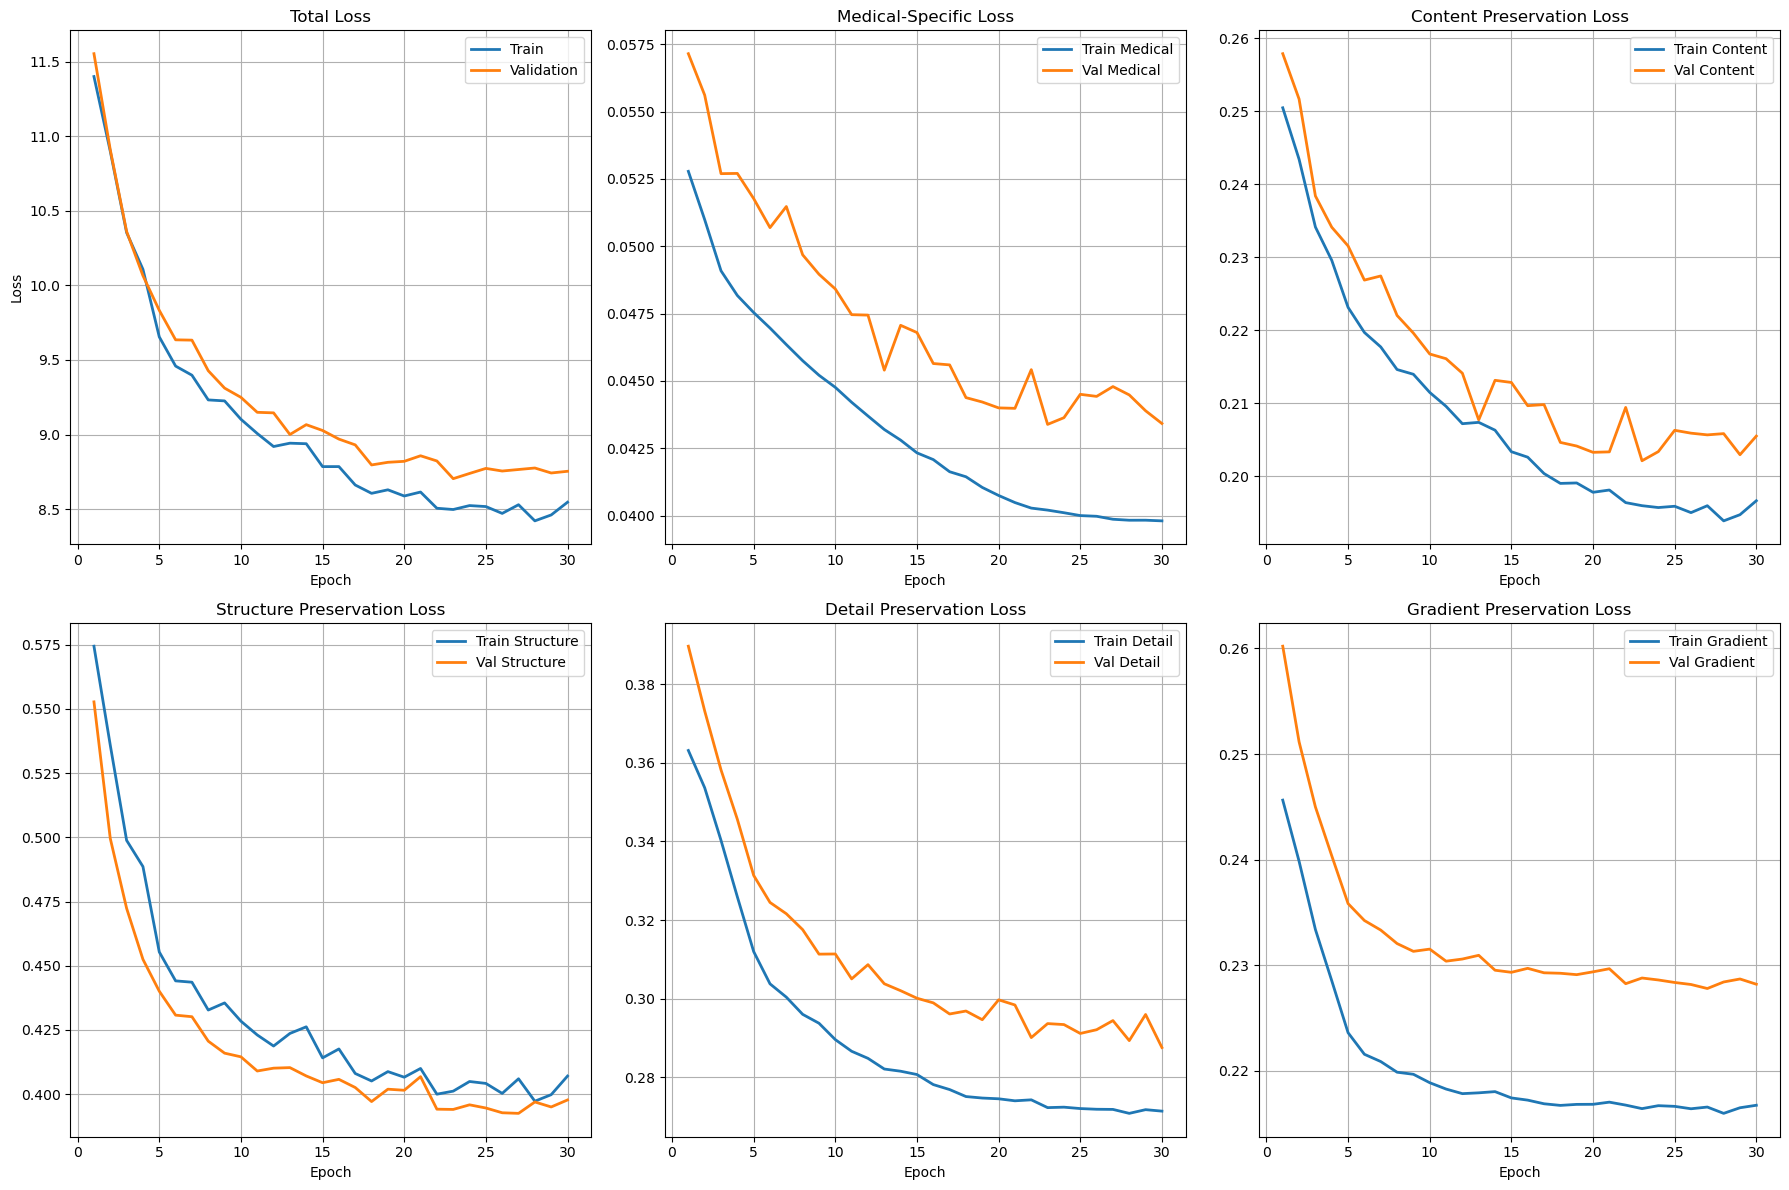

🖼️  Generating fusion visualizations...


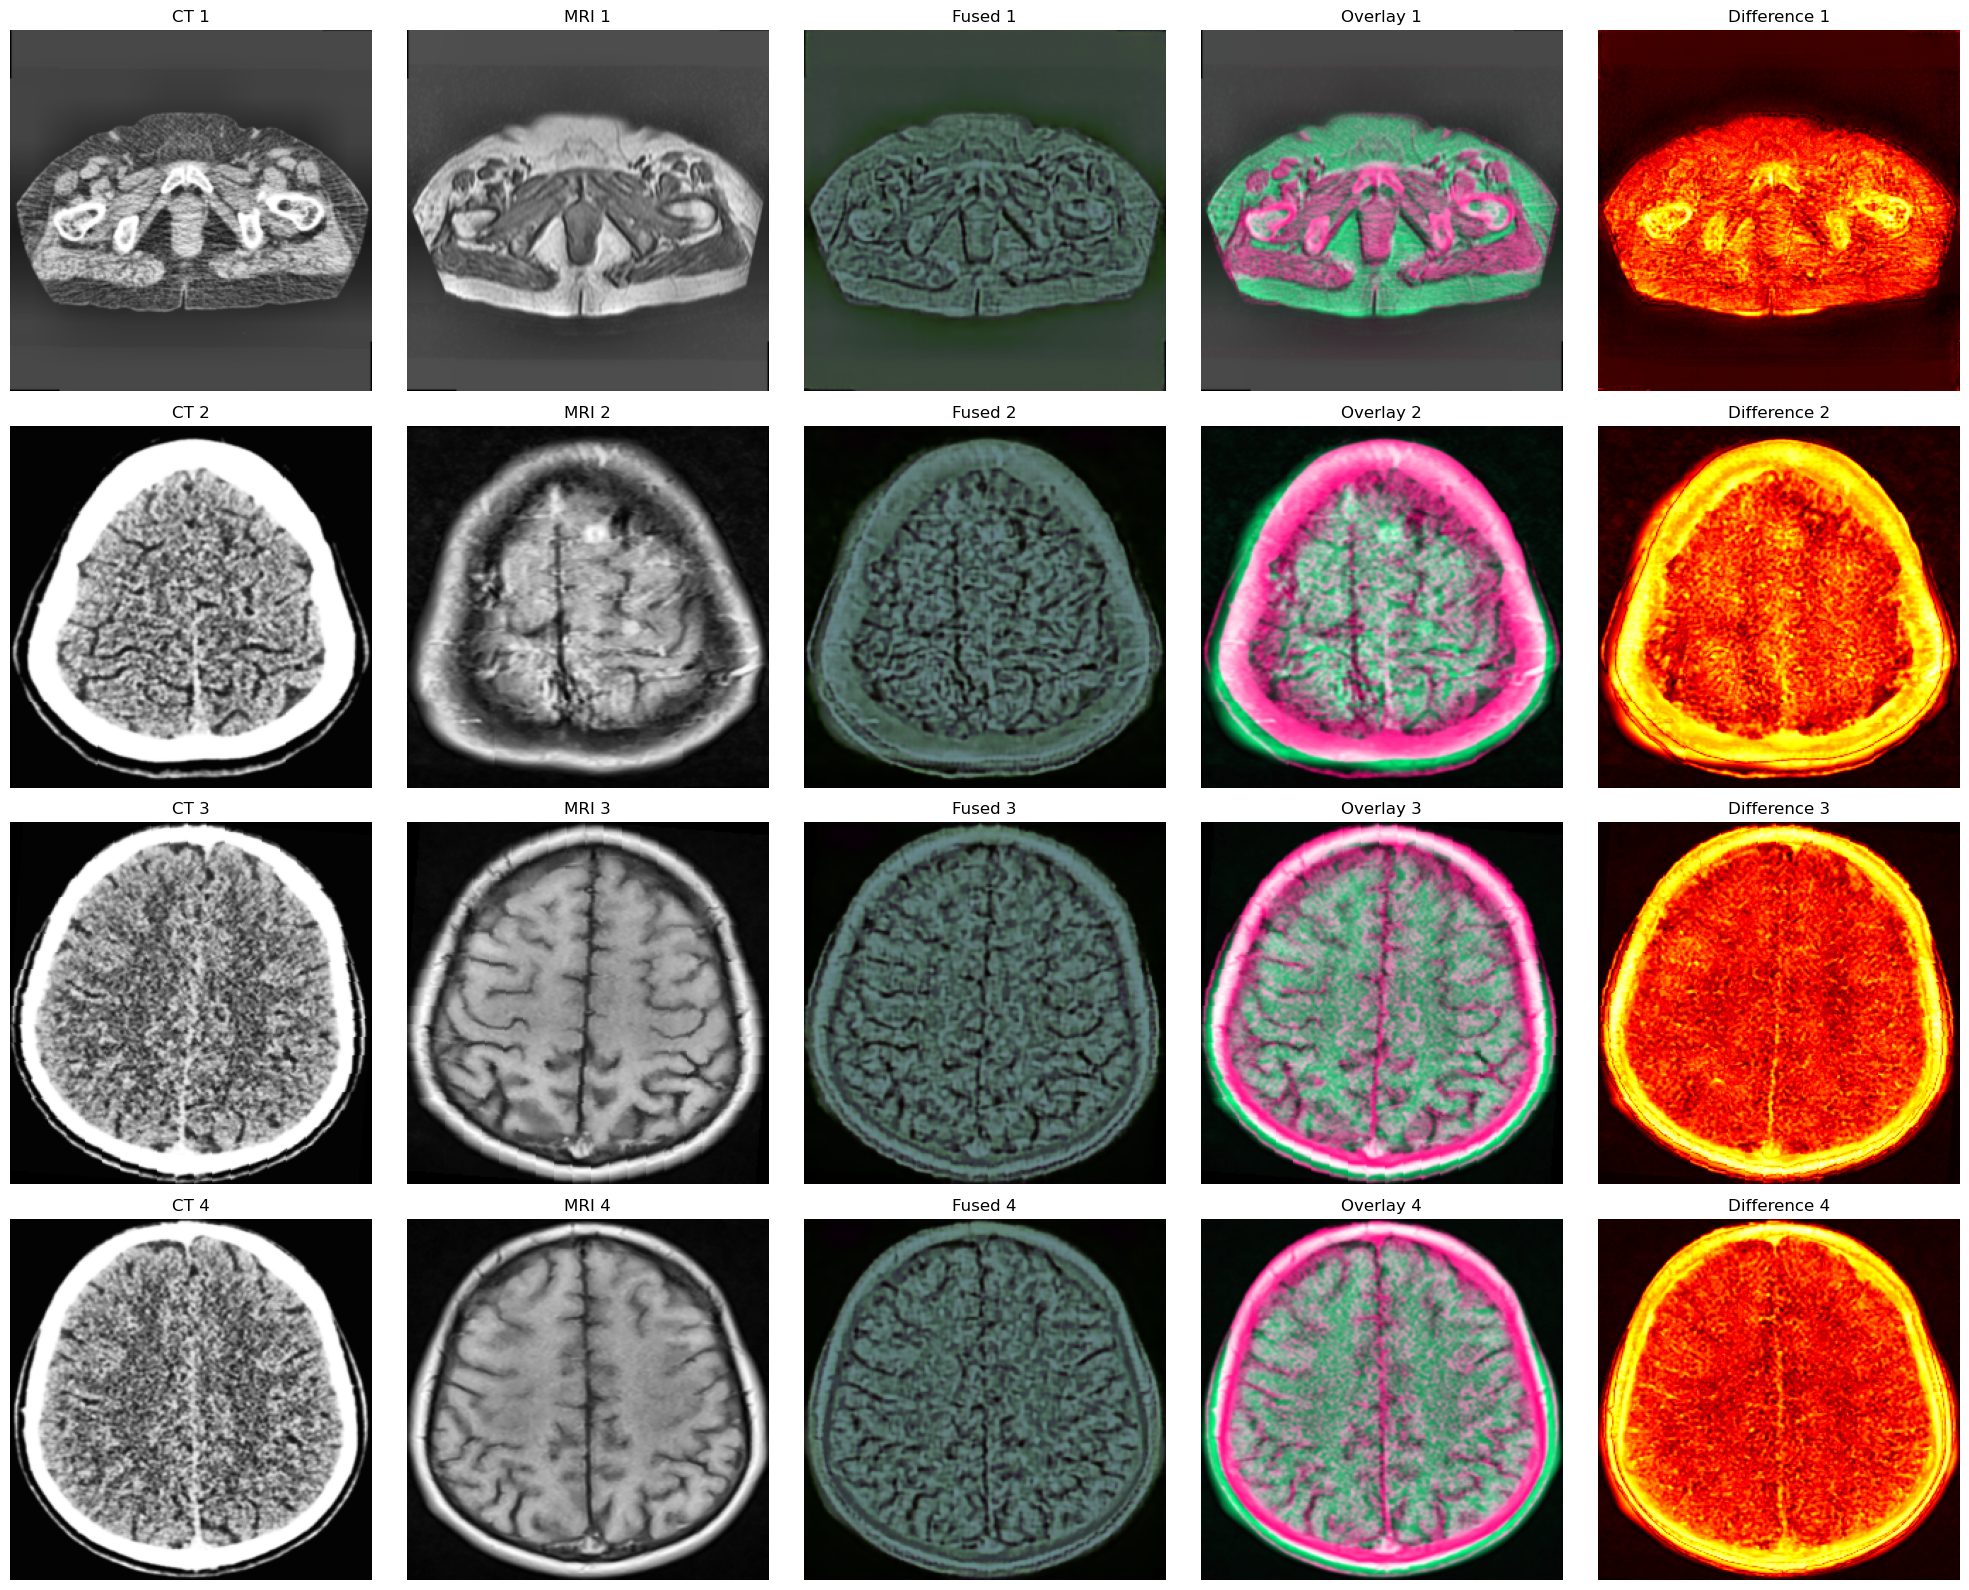

📈 Evaluating fusion performance...
Evaluating medical fusion performance...


Evaluating: 100%|██████████| 58/58 [00:02<00:00, 25.19it/s]


MEDICAL FUSION EVALUATION RESULTS
SSIM_CT:
  Mean: 0.5384 ± 0.1049
  Median: 0.5401
SSIM_MRI:
  Mean: 0.6419 ± 0.0823
  Median: 0.6506
PSNR_CT:
  Mean: 11.5924 ± 1.8778
  Median: 11.4438
PSNR_MRI:
  Mean: 16.0022 ± 1.6731
  Median: 15.7618
MUTUAL_INFO:
  Mean: 0.6169 ± 0.1145
  Median: 0.6169
EDGE_PRESERVATION:
  Mean: 0.7870 ± 0.0562
  Median: 0.8030

MEDICAL FINE-TUNING COMPLETED SUCCESSFULLY!
✓ Fine-tuned model saved: checkpoints/final/medical_fusion_finetuning/medical_fusion_finetuned.pth
✓ Training curves saved: results/medical_fusion_finetuning/plots/medical_training_curves.png
✓ Fusion results saved: results/medical_fusion_finetuning/plots/medical_fusion_results.png
✓ Evaluation metrics saved: results/medical_fusion_finetuning/medical_fusion_evaluation.json
✓ Training history saved: results/medical_fusion_finetuning/training_history.pt

🏥 Ready for medical image fusion applications!

🎉 Medical fine-tuning completed successfully!

📋 KEY FEATURES OF MEDICAL FINE-TUNING:
✓ Adapted

In [13]:

# ================================
# INFERENCE FUNCTION FOR NEW IMAGES
# ================================

def inference_medical_fusion(ct_path, mri_path, model_path=None):
    """Perform inference on new CT-MRI pair"""
    if model_path is None:
        model_path = config['save_path']
    
    print(f"Loading model from {model_path}...")
    
    # Load model
    model = MedicalFusionModel().to(config['device'])
    checkpoint = torch.load(model_path, map_location=config['device'])
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    # Load and preprocess images
    print("Loading and preprocessing images...")
    ct_img = MedicalImageProcessor.load_dicom_or_nifti(ct_path)
    mri_img = MedicalImageProcessor.load_dicom_or_nifti(mri_path)
    
    ct_img = MedicalImageProcessor.prepare_medical_image(ct_img, 'CT')
    mri_img = MedicalImageProcessor.prepare_medical_image(mri_img, 'MRI')
    
    # Prepare for model
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(config['image_size']),
        transforms.ToTensor(),
    ])
    
    # Make square and apply transforms
    def make_square(img):
        h, w = img.shape
        size = min(h, w)
        start_h, start_w = (h - size) // 2, (w - size) // 2
        return img[start_h:start_h+size, start_w:start_w+size]
    
    ct_img = make_square(ct_img)
    mri_img = make_square(mri_img)
    
    ct_tensor = transform(ct_img).unsqueeze(0)
    mri_tensor = transform(mri_img).unsqueeze(0)
    
    if ct_tensor.shape[1] == 1:
        ct_tensor = ct_tensor.repeat(1, 3, 1, 1)
    
    ct_tensor = ct_tensor.to(config['device'])
    mri_tensor = mri_tensor.to(config['device'])
    
    # Perform fusion
    print("Performing fusion...")
    with torch.no_grad():
        fused = model(ct_tensor, mri_tensor)
    
    # Convert back to numpy
    fused_np = fused[0].cpu().permute(1, 2, 0).numpy()
    ct_np = ct_tensor[0].cpu().permute(1, 2, 0).numpy()
    mri_np = mri_tensor[0, 0].cpu().numpy()
    
    # Visualize
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(ct_np)
    axes[0].set_title('CT Input')
    axes[0].axis('off')
    
    axes[1].imshow(mri_np, cmap='gray')
    axes[1].set_title('MRI Input')
    axes[1].axis('off')
    
    axes[2].imshow(fused_np)
    axes[2].set_title('Fused Result')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.savefig(f"{config['plots_dir']}/inference_result.png", dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"✓ Fusion completed! Result saved as {config['plots_dir']}/inference_result.png")
    return fused_np

if __name__ == "__main__":
    # Run the complete fine-tuning pipeline
    model = main()
    
    if model is not None:
        print("\n🎉 Medical fine-tuning completed successfully!")
        print("\n📋 KEY FEATURES OF MEDICAL FINE-TUNING:")
        print("✓ Adapted pre-trained visible-infrared model for CT-MRI fusion")
        print("✓ Medical-specific loss functions for diagnostic preservation")
        print("✓ Specialized preprocessing for medical image formats") 
        print("✓ Comprehensive evaluation with medical imaging metrics")
        print("✓ Ready for clinical CT-MRI fusion applications!")
        
        # Example of how to use for inference
        print("\n📝 USAGE EXAMPLE:")
        print("# For inference on new CT-MRI pairs:")
        print("fused_image = inference_medical_fusion('path/to/ct.png', 'path/to/mri.png')")
    
    print("\n🏥 Medical image fusion model is ready for deployment!")